In [19]:
import trackpy as tp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

framerate = 4.476307798086289
microns_per_pixel = 72307  # I think

In [53]:
data = pd.read_csv(
    "data/trajectories/1a6_2b9_steps_trays_diff/20241015-135643.9310850_WT_multichannel_aligned_drift_corrected_1_link2_traylen3.tray.csv"
)
print(data)

      Unnamed: 0  frame          x  ...       mass  particle  length
0              0      0  68.437546  ...  2740.3018         0    1619
1              1      1  68.487270  ...  2041.3729         0    1619
2              2      2  68.713920  ...  1799.0780         0    1619
3              3      3  68.552680  ...  2202.0503         0    1619
4              4      4  68.561386  ...  2342.2722         0    1619
...          ...    ...        ...  ...        ...       ...     ...
3212        4668   3873  24.998432  ...  2565.2940      1486       7
3213        4669   3874  25.349127  ...  1867.7698      1486       7
3214        4670   3875  25.517662  ...  3628.8340      1486       7
3215        4671   3876  25.376032  ...  3374.8936      1486       7
3216        4672   3877  25.367512  ...  4092.4756      1486       7

[3217 rows x 15 columns]


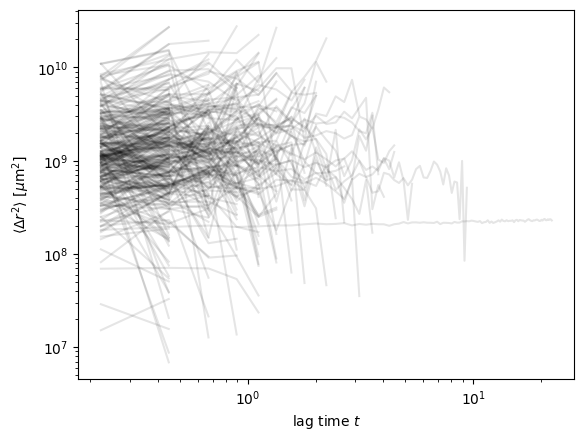

In [54]:
im = tp.imsd(data, microns_per_pixel, framerate)
fig, ax = plt.subplots()
ax.plot(im.index, im, "k-", alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r"$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]", xlabel="lag time $t$")
ax.set_xscale("log")
ax.set_yscale("log")

[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

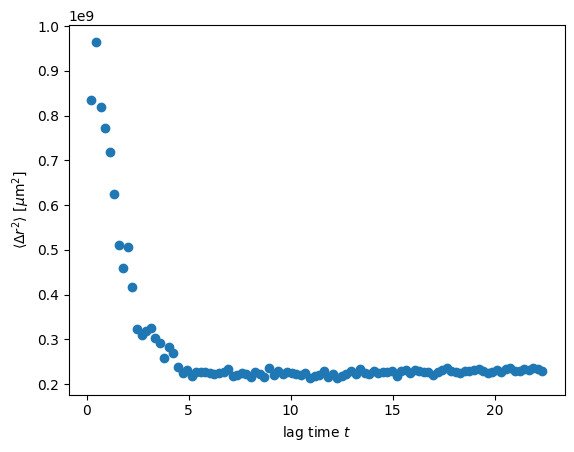

In [55]:
em = tp.emsd(data, microns_per_pixel, framerate)

fig, ax = plt.subplots()
ax.plot(em.index, em, "o")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set(ylabel=r"$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]", xlabel="lag time $t$")
# ax.set(ylim=(1e-2, 10))